In [2]:
%load_ext autoreload
%autoreload 2
%aimport -numpy, -matplotlib, -IPython
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import l2a_analysis as l2aa
from helpers import get_stats_average, plot_true_color_image, plot_difference_histogram, multiplot_difference_histogram



In [3]:
locs = {
    "CH": "S2A_MSIL1C_20230903T101601_N0509_R065_T32TMS_20230903T140124.SAFE",
    "BRA": "S2A_MSIL1C_20230909T141721_N0509_R010_T21MTS_20230909T192148.SAFE",
    "ALG": "S2B_MSIL1C_20230904T103629_N0509_R008_T30RXT_20230904T125735.SAFE",
}

reference_modifications = [
    {
        "flag": "SEN2COR_REFERENCE",
        "value": "",
        "info": "Reference product",
        "name": "REFERENCE",
    }
]

lut_modifications = [
    {
        "flag": "SEN2COR_MODIFY_LUT_AEROSOL",
        "value": "MARITIME",
        "info": "Look Up Table Aerosol set to MARITIME",
        "name": "LUT_AEROSOL_MARITIME",
    },
    {
        "flag": "SEN2COR_MODIFY_LUT_SEASON",
        "value": "WINTER",
        "info": "Look Up Table Mid Latitude Season set to WINTER",
        "name": "LUT_SEASON_WINTER",
    },
    {
        "flag": "SEN2COR_MODIFY_LUT_OZONE",
        "value": "250",
        "info": "Look Up Table Ozone set to 250",
        "name": "LUT_OZONE_250",
    },
    {
        "flag": "SEN2COR_MODIFY_LUT_OZONE",
        "value": "331",
        "info": "Look Up Table Ozone set to 331 (standard mid latitude summer)",
        "name": "LUT_OZONE_331",
    },
    {
        "flag": "SEN2COR_MODIFY_LUT_OZONE",
        "value": "450",
        "info": "Look Up Table Ozone set to 450",
        "name": "LUT_OZONE_450",
    },
]

flag_modifications = [
    {
        "flag": "SEN2COR_MODIFY_FLAGS_WV",
        "value": "0",
        "info": "Turn off water vapour correction",
        "name": "FLAG_WV_OFF",
    },
    {
        "flag": "SEN2COR_MODIFY_FLAGS_CIRRUS",
        "value": "FALSE",
        "info": "Turn off cirrus correction",
        "name": "FLAG_CIRRUS_OFF",
    },
    {
        "flag": "SEN2COR_MODIFY_FLAGS_BRDF",
        "value": "1",
        "info": "Set BRDF correction to 1",
        "name": "FLAG_BRDF_1",
    },
    {
        "flag": "SEN2COR_MODIFY_FLAGS_BRDF",
        "value": "2",
        "info": "Set BRDF correction to 2",
        "name": "FLAG_BRDF_2",
    },
    {
        "flag": "SEN2COR_MODIFY_CALIB_VISIBILITY",
        "value": "20",
        "info": "Set visibility to 20km",
        "name": "CALIB_VISIBILITY_20",
    },
    {
        "flag": "SEN2COR_MODIFY_CALIB_VISIBILITY",
        "value": "80",
        "info": "Set visibility to 80km",
        "name": "CALIB_VISIBILITY_80",
    },
    {
        "flag": "SEN2COR_MODIFY_CALIB_VISIBILITY",
        "value": "120",
        "info": "Set visibility to 120km",
        "name": "CALIB_VISIBILITY_120",
    },
]

class_modifications = [
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "0",
        "info": "Set whole SCL layer to NO_DATA",
        "name": "class_NO_DATA",
    },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '1',
    #     'info' : 'Set whole SCL layer to SATURATED_OR_DEFECTIVE',
    #     'name' : 'class_SATURATED_OR_DEFECTIVE'
    # },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "2",
        "info": "Set whole SCL layer to CASTED_SHADOWS",
        "name": "class_CASTED_SHADOWS",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "3",
        "info": "Set whole SCL layer to CLOUD_SHADOWS",
        "name": "class_CLOUD_SHADOWS",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "4",
        "info": "Set whole SCL layer to VEGETATION",
        "name": "class_VEGETATION",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "5",
        "info": "Set whole SCL layer to NOT_VEGETATED",
        "name": "class_NOT_VEGETATED",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "6",
        "info": "Set whole SCL layer to WATER",
        "name": "class_WATER",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "7",
        "info": "Set whole SCL layer to UNCLASSIFIED",
        "name": "class_UNCLASSIFIED",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "8",
        "info": "Set whole SCL layer to CLOUD_MEDIUM_PROBABILITY",
        "name": "class_CLOUD_MEDIUM_PROBABILITY",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "9",
        "info": "Set whole SCL layer to CLOUD_HIGH_PROBABILITY",
        "name": "class_CLOUD_HIGH_PROBABILITY",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "10",
        "info": "Set whole SCL layer to THIN_CIRRUS",
        "name": "class_THIN_CIRRUS",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "11",
        "info": "Set whole SCL layer to SNOW",
        "name": "class_SNOW",
    },
]

In [4]:
mods = reference_modifications + lut_modifications + flag_modifications + class_modifications

l2a_analysis = l2aa.L2A_Analysis(report_name="TEST")
l2a_analysis.set_locations(locs)
l2a_analysis.set_modifications(mods)

In [5]:
l2a_analysis.run_sen2cor()
l2a_analysis.read_l2a_data()

CH:	reference already exists. Skipping...
BRA:	reference already exists. Skipping...
ALG:	reference already exists. Skipping...
CH:	REFERENCE already exists. Skipping...
BRA:	REFERENCE already exists. Skipping...
ALG:	REFERENCE already exists. Skipping...
CH:	LUT_AEROSOL_MARITIME already exists. Skipping...
BRA:	LUT_AEROSOL_MARITIME already exists. Skipping...
ALG:	LUT_AEROSOL_MARITIME already exists. Skipping...
CH:	LUT_SEASON_WINTER already exists. Skipping...
BRA:	LUT_SEASON_WINTER already exists. Skipping...
ALG:	LUT_SEASON_WINTER already exists. Skipping...
CH:	LUT_OZONE_250 already exists. Skipping...
BRA:	LUT_OZONE_250 already exists. Skipping...
ALG:	LUT_OZONE_250 already exists. Skipping...
Running sen2cor for CH: LUT_OZONE_331
Running command:  /scratch/toml/Sen2Cor-02.11.00-Linux64/bin/L2A_Process /scratch/toml/sentinel_2_data/locations/CH/S2A_MSIL1C_20230903T101601_N0509_R065_T32TMS_20230903T140124.SAFE --resolution 60 --GIP_L2A /home/toml/sen2cor/2.11/cfg/L2A_GIPP_custom.x

In [6]:
loc = 'CH'
mod = 'LUT_SEASON_WINTER'
stat_bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]
stats = get_stats_average(l2a_analysis.reference_bands[loc], l2a_analysis.modified_bands[loc][mod], stat_bands)
display(stats)


mean      9.221410
std      16.528713
max     223.888885
min     -46.666668
dtype: float32

In [7]:
l2a_analysis.get_modification_names()

['REFERENCE',
 'LUT_AEROSOL_MARITIME',
 'LUT_SEASON_WINTER',
 'LUT_OZONE_250',
 'LUT_OZONE_331',
 'LUT_OZONE_450',
 'FLAG_WV_OFF',
 'FLAG_CIRRUS_OFF',
 'FLAG_BRDF_1',
 'FLAG_BRDF_2',
 'CALIB_VISIBILITY_20',
 'CALIB_VISIBILITY_80',
 'CALIB_VISIBILITY_120',
 'class_NO_DATA',
 'class_CASTED_SHADOWS',
 'class_CLOUD_SHADOWS',
 'class_VEGETATION',
 'class_NOT_VEGETATED',
 'class_WATER',
 'class_UNCLASSIFIED',
 'class_CLOUD_MEDIUM_PROBABILITY',
 'class_CLOUD_HIGH_PROBABILITY',
 'class_THIN_CIRRUS',
 'class_SNOW']

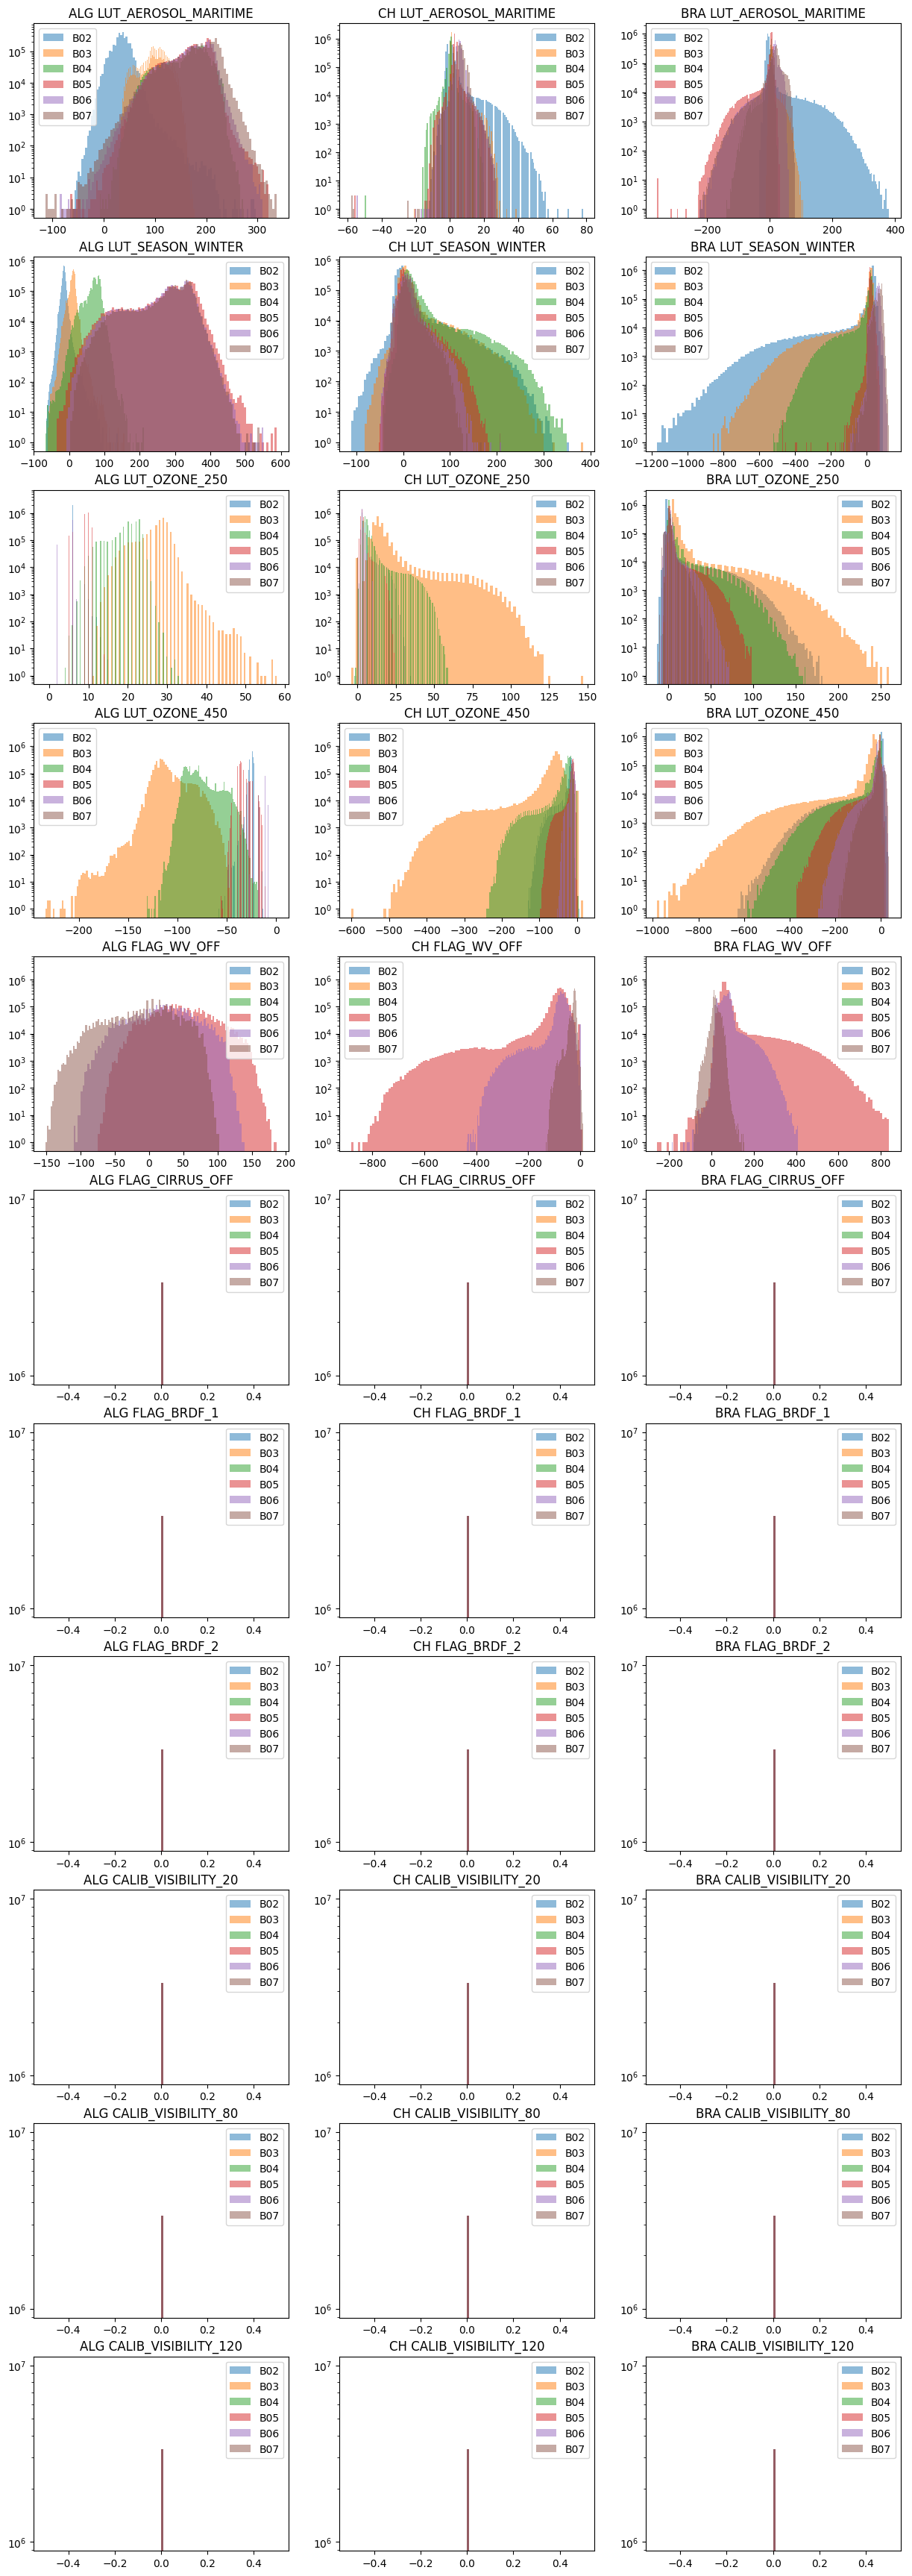

In [35]:
locs = ["ALG", "CH", "BRA"]
# bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]
bands = ["B02", "B03", "B04", "B05", "B06", "B07"]
# mods = ['SC_ONLY', 'class_NO_DATA']
mods = [
    # "class_NO_DATA",
    "LUT_AEROSOL_MARITIME",
    "LUT_SEASON_WINTER",
    "LUT_OZONE_250",
    "LUT_OZONE_450",
    "FLAG_WV_OFF",
    "FLAG_CIRRUS_OFF",
    "FLAG_BRDF_1",
    "FLAG_BRDF_2",
    "CALIB_VISIBILITY_20",
    "CALIB_VISIBILITY_80",
    "CALIB_VISIBILITY_120",
]
multiplot_difference_histogram(l2a_analysis, locs, mods, bands, share_axes=False)

In [9]:
from helpers import get_stats_average_multi
locs = ['ALG', 'CH', 'BRA']
# mods = ['class_NO_DATA',  'class_CLOUD_SHADOWS', 'class_VEGETATION', 'class_SNOW']
bands = ['B02', 'B03', 'B04']
# stats = get_stats_average_multi(l2a_analysis, locs, mods, bands)
# print("Standard Deviation")
# display(stats['std'])
# print("Mean")
# display(stats['mean'])
# print("Max")
# display(stats['max'])
# print("Min")
# display(stats['min'])


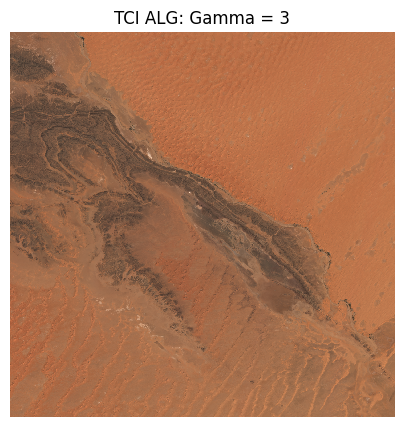

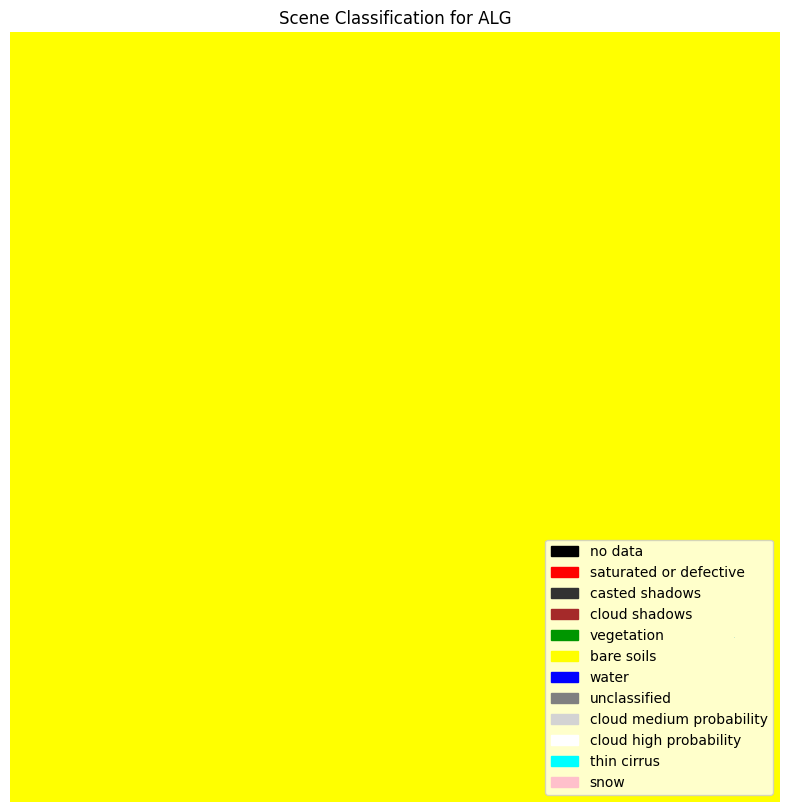

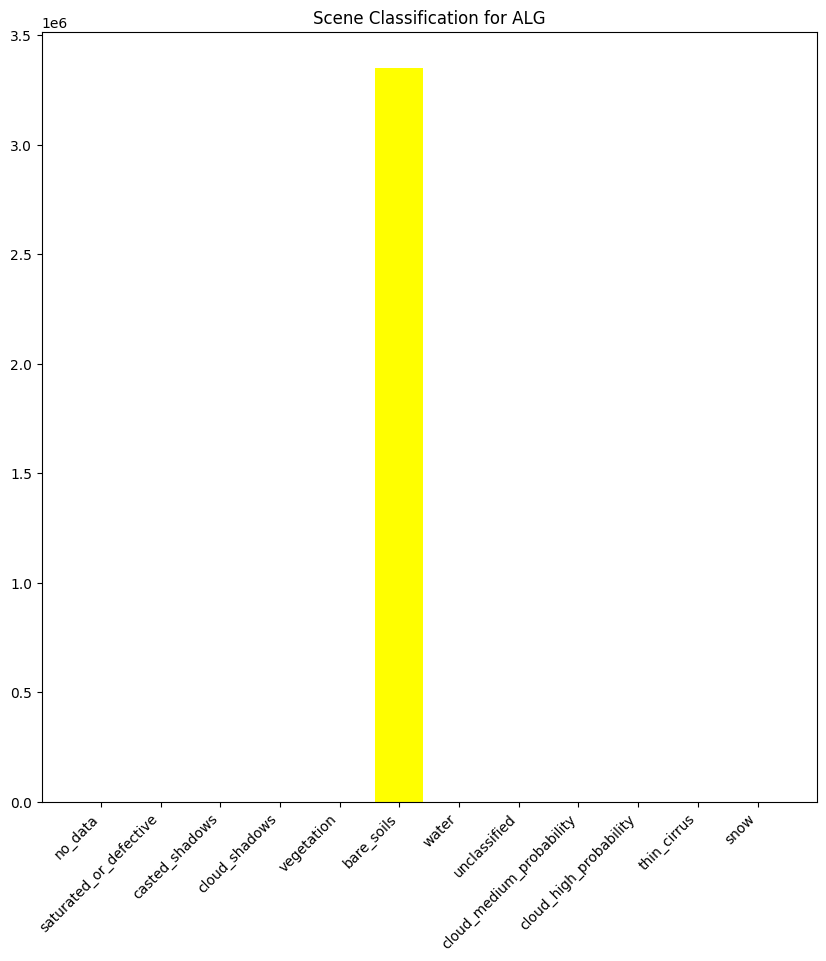

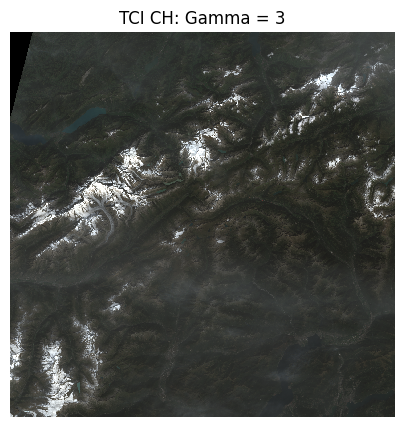

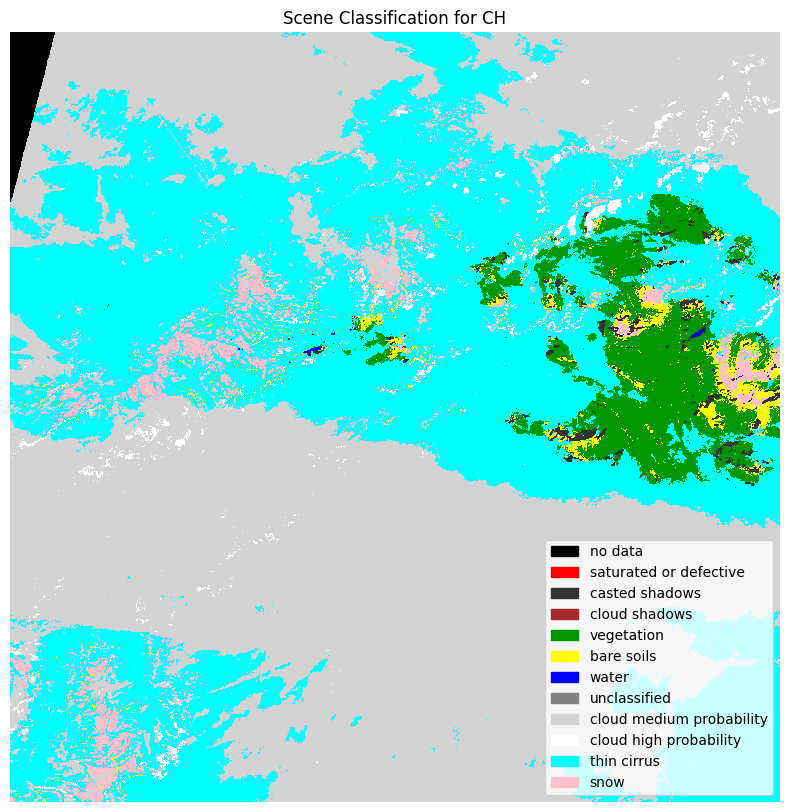

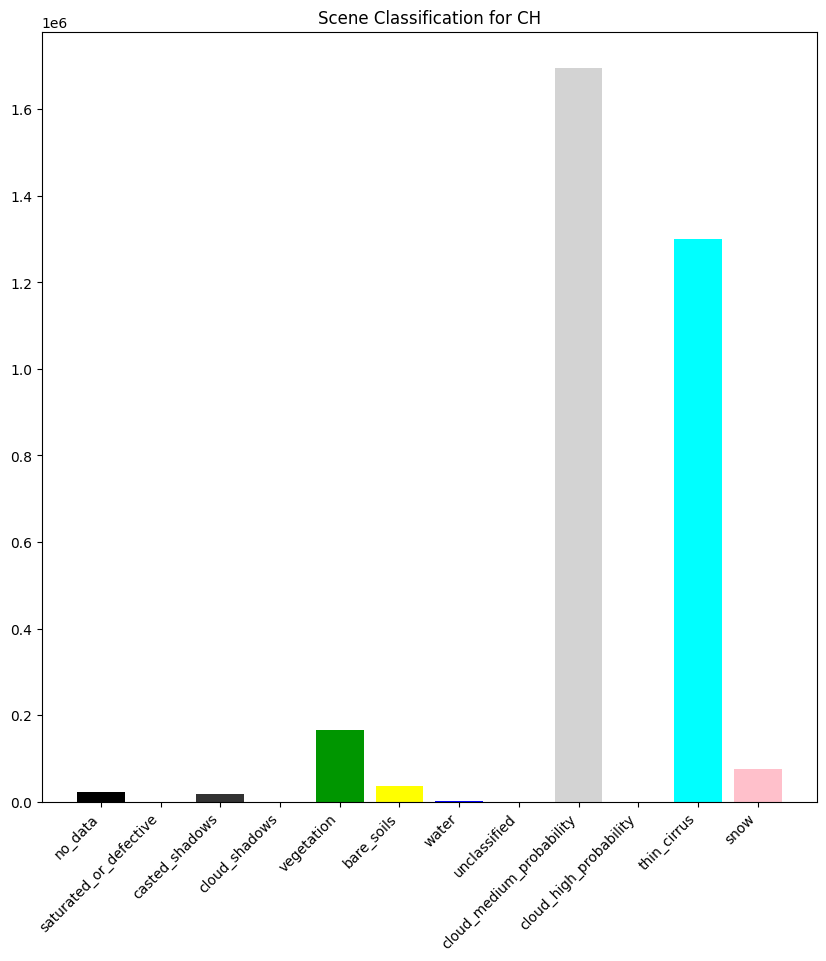

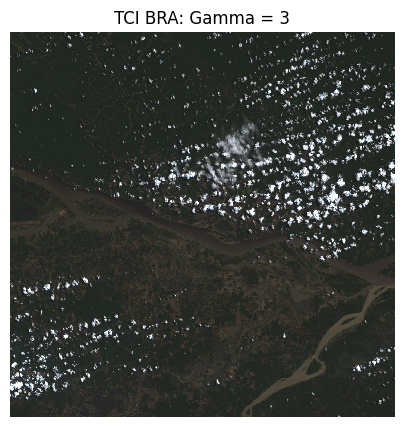

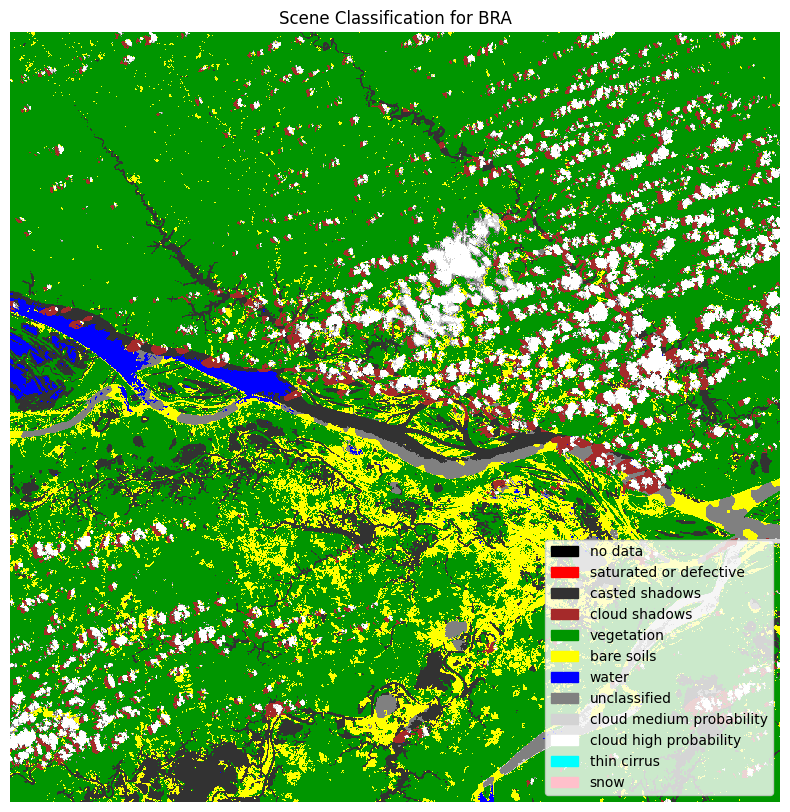

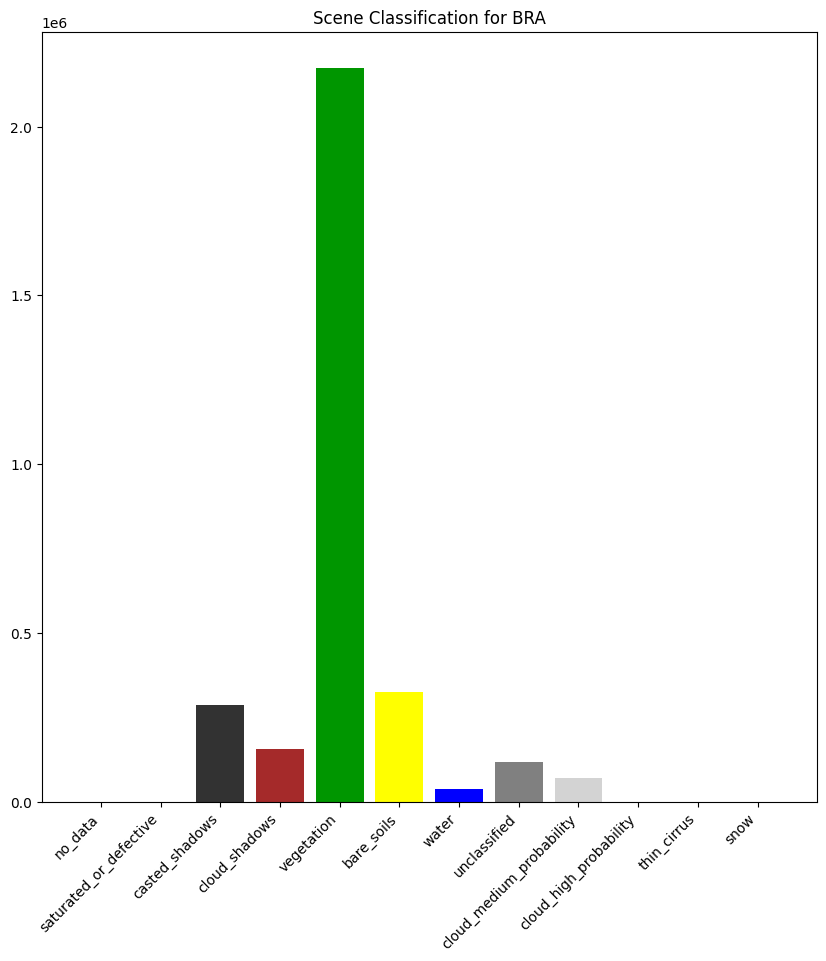

In [10]:
from helpers import plot_scl_in_rgb, plot_scl_as_bar_chart
for loc in locs:
    SCL = l2a_analysis.reference_bands[loc]['SCL']
    plot_true_color_image(l2a_analysis.reference_bands[loc], gamma=3, title=f"TCI {loc}: Gamma = 3", clip_value=10000)
    plot_scl_in_rgb(SCL, title=loc)
    plot_scl_as_bar_chart(l2a_analysis.reference_bands[loc], title=loc)


In [11]:
from helpers import get_max_difference_to_l2a
loc = 'CH'
bands = ['B02', 'B03', 'B04']
max_diffs, max_ids = get_max_difference_to_l2a(l2a_analysis, loc, mods, bands)

In [12]:
meta = l2a_analysis.reference_bands[loc]["B02"].meta

# total_diff = np.zeros((meta["height"], meta["width"]))
# for diff in max_diffs:
#     total_diff = np.maximum(total_diff, max_diffs[diff])

# with rio.open("outputs/total_diff_BRA.jp2", "w", **meta) as dst:
#     dst.write(total_diff, 1)


# for diff in max_diffs:
#     with rio.open(f"outputs/diff_{diff}.jp2", "w", **meta) as dst:
#         dst.write(max_diffs[diff], 1)

# for idx in max_ids:
#     with rio.open(f"outputs/id_{idx}.jp2", "w", **meta) as dst:
#         dst.write(max_ids[idx], 1)
# meta["count"] = len(max_diffs)
# with rio.open("outputs/difference.jp2", "w", **product["B02"].meta) as dst:
#     for i, diff in enumerate(max_diffs):
#         dst.write(max_diffs[diff], i+1)

from helpers import export_to_jp2

export_to_jp2(max_diffs, ["B02", "B03", "B04"], "outputs/difference_CH.jp2", meta)


In [28]:
from helpers import get_comparison_matrices, get_modification_names
loc = 'BRA'
mods = get_modification_names(class_modifications)
mods.remove('class_NO_DATA')
bands = ["B02", "B03", "B04"]
comp_matrix = get_comparison_matrices(l2a_analysis, loc, mods, bands)

In [29]:
comp_matrix

mean                      \
                               class_CASTED_SHADOWS class_CLOUD_SHADOWS   
class_CASTED_SHADOWS                       0.000000            0.000000   
class_CLOUD_SHADOWS                        0.000000            0.000000   
class_VEGETATION                          11.076718           11.076718   
class_NOT_VEGETATED                       16.788038           16.788038   
class_WATER                                0.000000            0.000000   
class_UNCLASSIFIED                         0.155159            0.155159   
class_CLOUD_MEDIUM_PROBABILITY             0.155159            0.155159   
class_CLOUD_HIGH_PROBABILITY               0.155159            0.155159   
class_THIN_CIRRUS                          0.155159            0.155159   
class_SNOW                                 0.000000            0.000000   

                                                                     \
                               class_VEGETATION class_NOT_VEGETATED   
class_CASTED_SHADOWS                 -11.076718          -16.788038   
class_CLOUD_SHADOWS                  -11.076718          -16.788038   
class_VEGETATION                       0.000000           -5.711319   
class_NOT_VEGETATED                    5.711319            0.000000   
class_WATER                          -11.076718          -16.788038   
class_UNCLASSIFIED                   -10.921561          -16.632883   
class_CLOUD_MEDIUM_PROBABILITY       -10.921561          -16.632883   
class_CLOUD_HIGH_PROBABILITY         -10.921561          -16.632883   
class_THIN_CIRRUS                    -10.921561          -16.632883   
class_SNOW                           -11.076718          -16.788038   

                                                               \
                               class_WATER class_UNCLASSIFIED   
class_CASTED_SHADOWS              0.000000          -0.155159   
class_CLOUD_SHADOWS               0.000000          -0.155159   
class_VEGETATION                 11.076718          10.921561   
class_NOT_VEGETATED              16.788038          16.632883   
class_WATER                       0.000000          -0.155159   
class_UNCLASSIFIED                0.155159           0.000000   
class_CLOUD_MEDIUM_PROBABILITY    0.155159           0.000000   
class_CLOUD_HIGH_PROBABILITY      0.155159           0.000000   
class_THIN_CIRRUS                 0.155159           0.000000   
class_SNOW                        0.000000          -0.155159   

                                                               \
                               class_CLOUD_MEDIUM_PROBABILITY   
class_CASTED_SHADOWS                                -0.155159   
class_CLOUD_SHADOWS                                 -0.155159   
class_VEGETATION                                    10.921561   
class_NOT_VEGETATED                                 16.632883   
class_WATER                                         -0.155159   
class_UNCLASSIFIED                                   0.000000   
class_CLOUD_MEDIUM_PROBABILITY                       0.000000   
class_CLOUD_HIGH_PROBABILITY                         0.000000   
class_THIN_CIRRUS                                    0.000000   
class_SNOW                                          -0.155159   

                                                                               \
                               class_CLOUD_HIGH_PROBABILITY class_THIN_CIRRUS   
class_CASTED_SHADOWS                              -0.155159         -0.155159   
class_CLOUD_SHADOWS                               -0.155159         -0.155159   
class_VEGETATION                                  10.921561         10.921561   
class_NOT_VEGETATED                               16.632883         16.632883   
class_WATER                                       -0.155159         -0.155159   
class_UNCLASSIFIED                                 0.000000          0.000000   
class_CLOUD_MEDIUM_PROBABILITY                     0.000000          0.000000   
cl

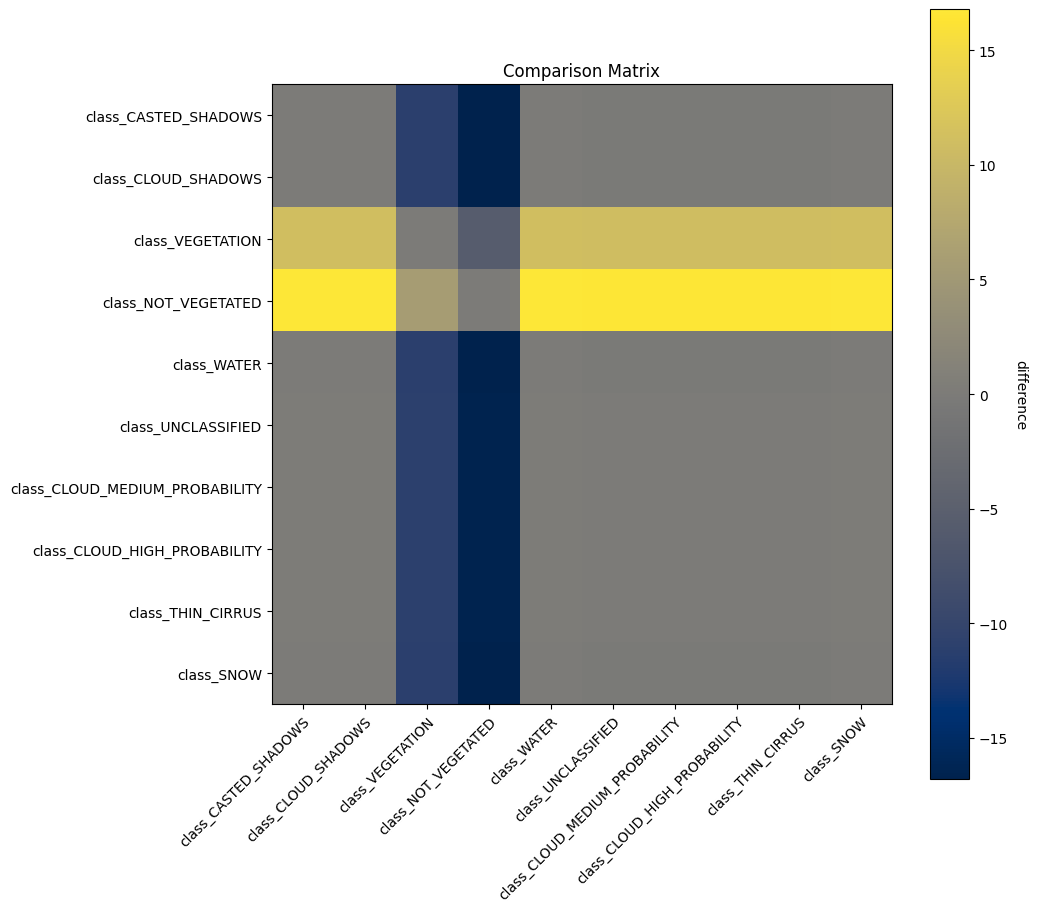

In [36]:
from helpers import plot_comparison_matrix
plot_comparison_matrix(comp_matrix["mean"])


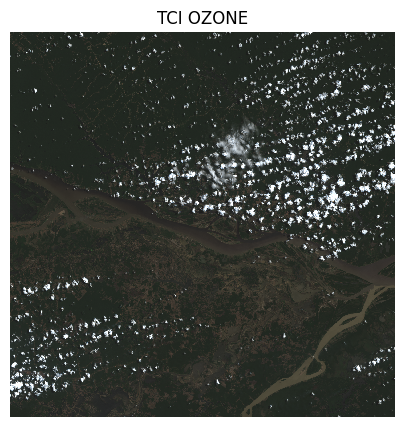

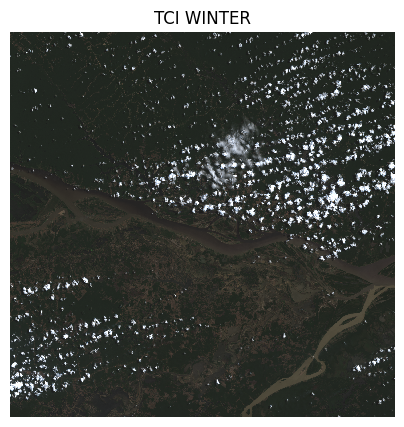

In [ ]:
plot_true_color_image(l2a_analysis.modified_bands[loc]["LUT_OZONE_450"], gamma=3, title=f"TCI OZONE", clip_value=10000)
plot_true_color_image(l2a_analysis.modified_bands[loc]["LUT_SEASON_WINTER"], gamma=3, title=f"TCI WINTER", clip_value=10000)


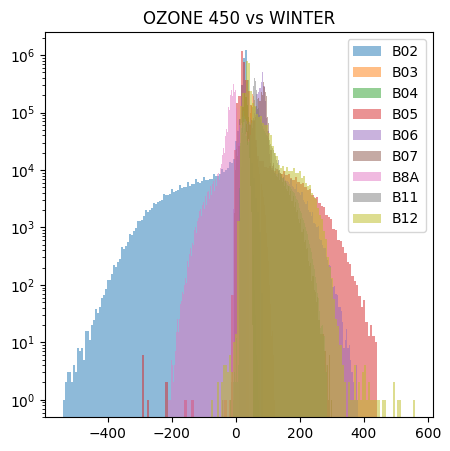

In [ ]:
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]

ref = l2a_analysis.modified_bands[loc]["LUT_OZONE_450"]
mod = l2a_analysis.modified_bands[loc]["LUT_SEASON_WINTER"]
plot_difference_histogram(ref,mod, bands, title="OZONE 450 vs WINTER")